# Model training

## Environment setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
WORKING_PATH = '/content/drive/MyDrive/KeepCoding/NLP/exercise'


In [ ]:
%cd {WORKING_PATH}

/content/drive/MyDrive/KeepCoding/NLP/exercise


In [ ]:
!pip install -r requirements.tx

In [ ]:
import sys
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.preprocessing import normalize
from sklearn.metrics import f1_score, precision_score, make_scorer, classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib
import matplotlib.pyplot as plt


In [ ]:
# to load custom libraries
sys.path.append(WORKING_PATH)

# load custom libraries

### Bag-of-Words features

For the bag-of-words matrix generation, unigrams and bigrams (1- and 2-word n-grams) were considered. During the initial exploratory data analysis phase, it was observed that certain bigrams occurred frequently and could be informative for predicting review labels. To avoid an excessive increase in feature dimensionality when including bigrams, filtering was applied using the min_df parameter. The max_df parameter was not employed, as exhaustive stop word removal had already been performed during text preprocessing. Similarly, max_features was omitted, as feature selection was planned to be subsequently carried out using the chi-square test.

In [ ]:
cache_dir = "cache"
def extract_BoW_features(words_train, words_test,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """
    Extract Bag-of-Words for a given set of documents
    Input is already preprocessed into words.
    Data could be caching/loading processed for efficiency
    """

    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass

    if cache_data is None:
        vectorizer = CountVectorizer(ngram_range=(1,2),
                                     min_df = 0.001,
                                     preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
        vectorizer.fit(words_train)
        features_train = vectorizer.transform(words_train)
        features_test = vectorizer.transform(words_test)
        vocabulary = vectorizer.vocabulary_

        if cache_file is not None:
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                 joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])

    return features_train, features_test, vocabulary

In [ ]:
cache_file_preproc = "preprocessed_data.pkl"
try:
  with open(os.path.join(cache_dir, cache_file_preproc), "rb") as f:
            cache_data = pickle.load(f)
  print("Read preprocessed data from cache file:", cache_file_preproc)
except:
  pass

words_train = cache_data['words_train']
words_test = cache_data['words_test']
labels_train = cache_data['labels_train']
labels_test = cache_data['labels_test']

features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test, cache_dir = cache_dir)

Read preprocessed data from cache file: preprocessed_data.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Wrote features to cache file: bow_features.pkl


### Feature selection (Chi-square test)

The chi-square test is used to select the most informative features. The p-value returned by the test is employed to retain features with a value below 0.001. The features showing the highest significance in this test are displayed, and some correlation with the words' semantic meaning is observed. It would be insightful to plot significance against feature occurrence frequency to examine their relationship.

In [ ]:
# Transform bag-of-words into one hot enconding matrix (more suitable for chi square test)
features_sign_train = np.sign(features_train.toarray())
# Get sorted words (features)
features = [term for term, _ in sorted(vocabulary.items(),key=lambda x: x[1])]

In [ ]:
# chi square test for each feature
chi2_pval = chi2(features_sign_train, labels_train)[1]
chi2_log10pval = -np.log10(chi2_pval)
scores = list(zip(features, chi2_pval, chi2_log10pval))
# select most relevant features
pvalue_cutoff = 0.001
features_sel  = [features for features, pval, _ in scores if pval < pvalue_cutoff]
print(f'Number of selected features with p-value below {pvalue_cutoff}: {len(features_sel)}')

Number of selected features with p-value below 0.001: 568


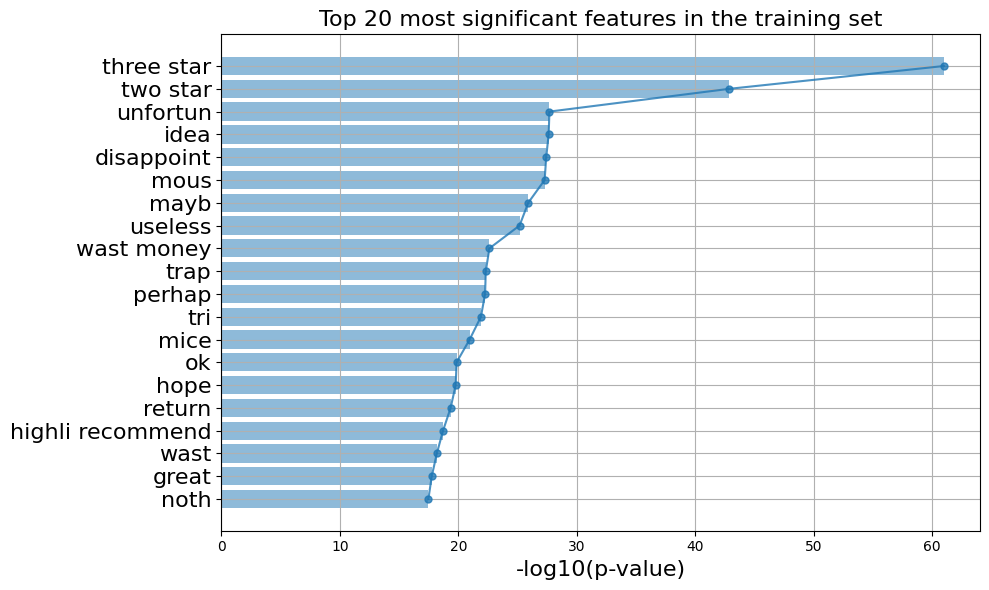

In [ ]:
# top20 most significant test for features
i = 20
sorted_scores = sorted(scores, key=lambda x: x[2])
top_features = list(zip(*sorted_scores[-i:]))
labels = top_features[0]
x = range(len(top_features[2]))

plt.figure(figsize=(10, 6))
plt.barh(x,top_features[2], align='center', alpha=0.5)
plt.plot(top_features[2], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=16)
plt.xlabel('-log10(p-value)', fontsize=16)
plt.title('Top {} most significant features in the training set'.format(i), fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Example of features with no significant test
i = 20
top_features = list(zip(*sorted_scores[:i]))
labels = top_features[0]
labels

('adventur',
 'and five',
 'ant crawl',
 'assess',
 'away elit',
 'back two',
 'blow around',
 'bore',
 'bottl hummingbird',
 'buildup',
 'buy replac',
 'buy sever',
 'ca',
 'care use',
 'catch kill',
 'cautiou',
 'certifi',
 'clasp',
 'come pre',
 'deer will')

In [ ]:
# TODO Plot -log10(p-value) vs number of ocurrences (df)

### Prepare data for train model

In [ ]:
# prepare X_data (1. feature selection)
features_index = [index for feature, index in vocabulary.items() if feature in features_sel]
features_select_train = features_train.toarray()[:,features_index]
features_select_test = features_test.toarray()[:,features_index]

# prepare X_data (2. normalize bag-of-words by row)
X_train = normalize(features_select_train, axis=1)
X_test = normalize(features_select_test, axis=1)

# prepare y_data
y_train = np.array(labels_train)
y_test = np.array(labels_test)

# save data
cache_dir = "cache"
cache_file_train = "train_model_data.pkl"
cache_data = dict(X_train=X_train, X_test=X_test,
                  y_train=y_train, y_test=y_test)
try:
  with open(os.path.join(cache_dir, cache_file_train), "wb") as f:
          joblib.dump(cache_data, f)
  print("Wrote data to train model to cache file:", cache_file_train)
except:
  pass



Wrote data to train model to cache file: train_model_data.pkl


### Scores for train the model

The parameter used for model selection depends on the study's objective. Selection must account for the imbalanced nature of the dataset, as certain metrics (e.g., micro-averaged precision) may produce biased results for the intended purpose. For this analysis, the macro-averaged F1-score has been selected, as it evaluates the model's comprehensive performance across all classes

In [ ]:
# macro precision is defined as score for GridSearchCV
macro_precision_scorer = make_scorer(
    precision_score,
    average='macro',
    zero_division=0
)
# macro precision is defined as score for GridSearchCV
macro_f1_scorer = make_scorer(
    f1_score,
    average='macro',
    zero_division=0
)

### Model I (Support Vector Classification)

In [ ]:
# parameters to check
params = {
  'C': [0.5, 0.6, 0.8, 1],
  'kernel': ['linear', 'rbf']
}
# search for the best parameters
grid = GridSearchCV(SVC(), params, cv=5, scoring=macro_f1_scorer, n_jobs = 2)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=2,
             param_grid={'C': [0.5, 0.6, 0.8, 1], 'kernel': ['linear', 'rbf']},
             scoring=make_scorer(f1_score, response_method='predict', average=macro, zero_division=0))

In [ ]:
print(f'Best score: {grid.best_score_}')
grid.best_params_

Best score: 0.6074421247292368


{'C': 1, 'kernel': 'linear'}

### Model II (Random forest)

In [ ]:
# parameters to check
params = {
  'max_depth': range(1,15),
}
# search for the best parameters
grid = GridSearchCV(RandomForestClassifier(), params, cv=5, scoring=macro_f1_scorer, n_jobs = 2)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'max_depth': range(1, 15)},
             scoring=make_scorer(f1_score, response_method='predict', average=macro, zero_division=0))

In [ ]:
print(f'Best score: {grid.best_score_}')
grid.best_params_

Best score: 0.4819738422065713


{'max_depth': 14}

In [ ]:
# TODO p-value threshold in GridSearchCV
# TODO add scores to GridSearchCV (recall 0)